# Plotting
#### A Guide to the 80 different plotting modules I have written
What works? What doesn't? Why?

In [3]:
import sys
sys.path.append(r"C:\ProgramData\Anaconda2\Lib\site-packages\pyMeasure\Documentation\SaraProject\NIST")
from TwoPortModels import *

## Plot_Params() - which uses Fitting to generate models

('s11:', {'l': 0.0009100022327460988})
('s12:', {'l': 0.0009092695149332596})
('s21:', {'l': 0.0009092695149332596})
('s22:', {'l': 0.0009100022327460988})


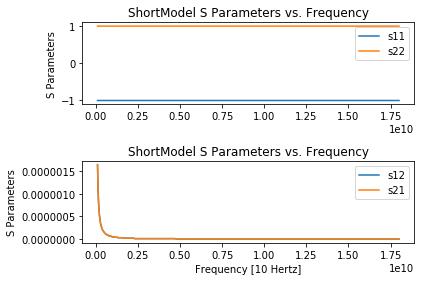

In [4]:
plot_params(ShortModel(), format='')

('s11:', {'zeta': 50.0})
('s12:', {'zeta': 50.000000000000036})
('s21:', {'zeta': 50.000000000000036})
('s22:', {'zeta': 49.9999992646516})


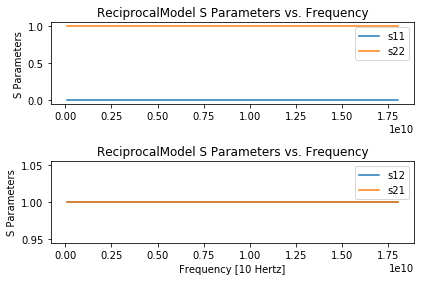

In [5]:
plot_params(ReciprocalModel(), format='')

### Straight Lines are Cool, what about complex models?

In theory, format='ri' would plot real component vs. imaginary component and format='mp' would plot magnitude and phase, <i> but</i> this doesn't happen <br/>
<b>Why?</b> <br/> <font color="red">minpack.error: Result from function call is not a proper array of floats.</font>
<b><br/>What does this mean?</b>
<br/> Scipy's least squares can't handle imaginary values - which should have been where separate_imag() saved the day, but alas.

## Plot()
At face value LMFIT seems like the dream - and I'm still holding out that it could be used to fix all of the scipy failure problems.<br/>
For some reason I only made this work for short and open models, not sure why. Will fix if time.

### Proof of Concept - Simple_Plot()

In [6]:
# simple_plot() serves as a proof of concept that LMFIT can fit these models and agrees with plot_params()
simple_plot(OpenModel(frequency=np.linspace(18E9, 19E9, 20)), fit_stats=True)

[[Fit Statistics]]
    # function evals   = 115
    # data points      = 20
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -629.804
    Bayesian info crit = -627.813
[[Variables]]
    c:    1.7579e-05 (init= 4.7e-05)
    z0:   49.9807663 (init= 50)


[array([  1.80000000e+10,   1.80526316e+10,   1.81052632e+10,
          1.81578947e+10,   1.82105263e+10,   1.82631579e+10,
          1.83157895e+10,   1.83684211e+10,   1.84210526e+10,
          1.84736842e+10,   1.85263158e+10,   1.85789474e+10,
          1.86315789e+10,   1.86842105e+10,   1.87368421e+10,
          1.87894737e+10,   1.88421053e+10,   1.88947368e+10,
          1.89473684e+10,   1.90000000e+10]),
 array([ 0.99999978,  1.00000019,  0.99999993,  1.00000021,  0.99999975,
         0.99999992,  1.00000001,  1.00000007,  0.99999995,  1.00000007,
         1.00000006,  1.00000009,  1.00000011,  0.99999986,  0.99999986,
         0.99999994,  0.99999982,  1.00000003,  1.00000011,  0.99999984]),
 array([ 0.99999998,  0.99999998,  0.99999998,  0.99999998,  0.99999998,
         0.99999998,  0.99999998,  0.99999998,  0.99999998,  0.99999998,
         0.99999998,  0.99999998,  0.99999998,  0.99999998,  0.99999998,
         0.99999998,  0.99999998,  0.99999998,  0.99999998,  0.999999

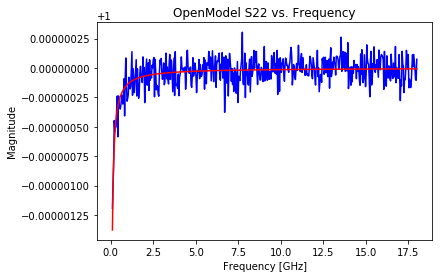

In [13]:
# You can also generate single graphs
plot(OpenModel(), index=3)

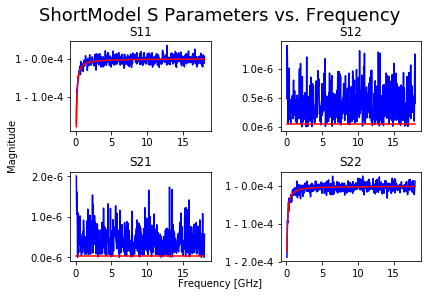

In [12]:
# Or multiple graphs
plot(ShortModel())

Less straight lines, what about complex models though?

## TPMComplexMaybe - A Radical Frontier
Based on: https://github.com/gitj/lmfit-py/blob/4fbd015f08208c0d64110629b4081c8836545ea5/examples/complex_resonator_model.ipynb

In [31]:
from TPMComplexMaybe import *
# TPMComplexMaybe serves as an experimental class and an attempt to do complex fitting using lmfit

In [40]:
short = ShortModel(complex=True)
true_params = short.make_params(z_0=short.z0, l_0_real=0, l_0_imag=short.l0, l_1_real=0, l_1_imag=short.l1, f_0=100)
# Note: the default freq is (1E8, 18E9), but the model and fit don't agree at low freqs, so I have decrease the range
freq = np.linspace(17E9, 18E9, 100)
# Really little noise b/c expect magnitudes of 10^-9
noise_scale = 3E-10
# These are the true/theoretical values
true_s11 = short.eval(params=true_params, f=freq)
# These are measured/noisy values
measured_s11 = true_s11 + noise_scale*(np.random.randn(len(freq)) + 1j*np.random.randn(len(freq)))

def plot_ri(data, *args, **kwargs):
    plt.plot(data.real, data.imag, *args, **kwargs)


Default parameter input l0=l1=l2=1e-09


In [41]:
# We can use fit_report() to determine how well the fit went

# Guess at values uses noisy data and frequency
guess = short.guess(measured_s11, f=freq, verbose=False)
# Result does lmfit.fit using the data, your guess at the param values, and freq
result = short.fit(measured_s11, params=guess, f=freq, verbose=True,  method='cd')
print result.fit_report()

product:  5.8788061359e-32
[[Model]]
    Model(short_equation)
[[Fit Statistics]]
    # function evals   = 346
    # data points      = 200
    # variables        = 5
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -8674.502
    Bayesian info crit = -8658.010
[[Variables]]
    z_0:        2.0310e-05 (init= 55.93647)
    l_0_real:   0.00082681 (init= 0)
    l_0_imag:   2.6657e-11 (init= 1.857993e-11)
    l_1_real:  -4.9963e-09 (init= 0)
    l_1_imag:   1.6469e-21 (init= 1.045121e-21)



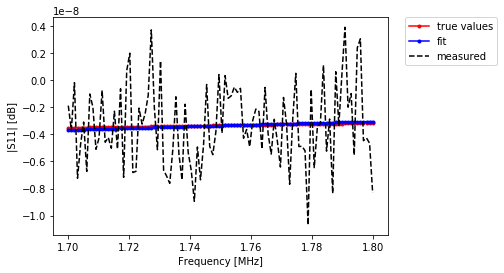

In [28]:
# We can use TPMComplexMaybe to plot complex S11, which is something we haven't been able to do previously
fit_s11 = short.eval(params=result.params, f=freq)
guess_s11 = short.eval(params=guess, f=freq)
plt.plot(freq/10**10, 20*np.log10(np.abs(true_s11)), 'r.-', label='true values')
# plt.plot(freq/10**10, 20*np.log10(np.abs(true_s11)), label='guess')
plt.plot(freq/10**10, 20*np.log10(np.abs(fit_s11)), 'b.-', label='fit')
plt.plot(freq/10**10, 20*np.log10(np.abs(measured_s11)), 'k--', label='measured')
plt.ticklabel_format(axis='y', style='')
plt.ylabel('|S11| [dB]')
plt.xlabel('Frequency [MHz]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

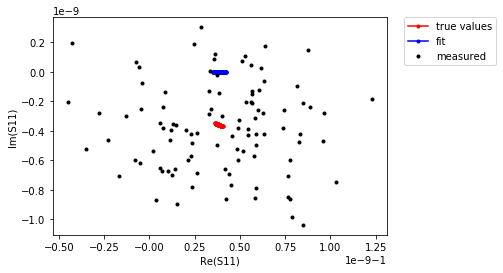

In [29]:
plot_ri(true_s11, 'r.-', label='true values')
plot_ri(fit_s11, 'b.-', label='fit')
plot_ri(measured_s11, 'k.', label='measured')
plt.xlabel('Re(S11)')
plt.ylabel('Im(S11)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [30]:
# unravel phase - look @ vals in list
# if change > pi/2 = jump
sys.path.append(r"C:\ProgramData\Anaconda2\Lib\site-packages\pyMeasure\Code\Analysis")
from SParameter import *